# CPE 490 590 Homework 3
## Author: Rahul Bhadani

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


## Practice

# 7. Classification with Neural Network (25 Points)


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Serif'
plt.rcParams['font.size'] = 15
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pandas as pd
# load dataset
data = pd.read_csv("https://raw.githubusercontent.com/rahulbhadani/CPE490_590_Sp2025/refs/heads/master/Data/Diabetes/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Part 1. Standardization

In [35]:
# Assuming that 'data' is your DataFrame and it includes an 'Outcome' column
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
x = data.loc[:, features].values
y = data.loc[:,['Outcome']].values
y = y.reshape(-1)

# Standardizing the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
# Split the data
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)


In [36]:
print(x.shape)

(768, 8)


## Part 2. Define the Neural Network

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
# Convert to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.LongTensor(y_train)
x_test_tensor = torch.FloatTensor(x_test)
y_test_tensor = torch.LongTensor(y_test)


class DiabetesNetwork(nn.Module):
    def __init__(self, n_feature):
        super(DiabetesNetwork, self).__init__()
        self.n_feature = n_feature
        self.fc1 = nn.Linear(n_feature, 4)
        self.fc2 = nn.Linear(4, 3)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(3, 2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.output_layer(x)
        return x

## Part 3.

In [38]:
model = DiabetesNetwork(x.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 1000
Losses = []
for epoch in range(epochs):
    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    Losses.append(loss.detach().item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 0.4327
Epoch [200/1000], Loss: 0.4205
Epoch [300/1000], Loss: 0.4165
Epoch [400/1000], Loss: 0.4030
Epoch [500/1000], Loss: 0.3930
Epoch [600/1000], Loss: 0.3900
Epoch [700/1000], Loss: 0.3866
Epoch [800/1000], Loss: 0.3862
Epoch [900/1000], Loss: 0.3864
Epoch [1000/1000], Loss: 0.3859


## Part 4.

Text(0, 0.5, 'Loss')

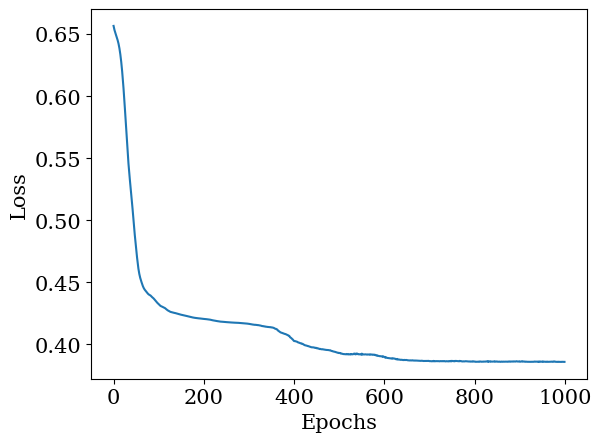

In [42]:
plt.plot(np.arange(0,epochs), Losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')


## Part 5. 

In [46]:
import onnxruntime as ort

# Evaluate the model
with torch.no_grad():
    outputs = model(x_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Test Accuracy: {accuracy:.4f}')

# Export the model to ONNX
dummy_input = torch.randn(1, x.shape[1])
input_names = ["input"]
output_names = ["output"]

torch.onnx.export(
    model, dummy_input, "diabetes_classifier.onnx",
    input_names=input_names, output_names=output_names,
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11  # Try a lower opset version like 11
)
print("Model saved as diabetes_classifier.onnx")

## save the scaler parameter
import json
with open("scaler_params.json", "w") as f:
    json.dump({ "mean": scaler.mean_.tolist(), "scale": scaler.scale_.tolist()
    }, f)
    
print("Scaler parameters saved as scaler_params.json")


Test Accuracy: 0.7338
Model saved as diabetes_classifier.onnx
Scaler parameters saved as scaler_params.json
ONNX Model Test Accuracy: 0.7338


## Part 6.

In [59]:
ort_session = ort.InferenceSession("diabetes_classifier.onnx")
# Prepare input
x_new = [[7, 149, 73, 94, 94, 32, 0.672, 45]]
x_new_scaled = scaler.transform(x_new)
ort_inputs = {ort_session.get_inputs()[0].name: x_new_scaled.astype(np.float32)}
# Run inference
ort_outputs = ort_session.run(None, ort_inputs)
# Calculate accuracy
ort_predicted = np.argmax(ort_outputs[0], axis=1)
print(ort_predicted)

[0]


# 8. Logistics Regression to Predict Equipment Failure (35 Points)

## Reading features

In [22]:
import pandas as pd
features = pd.read_csv("https://raw.githubusercontent.com/rahulbhadani/CPE490_590_Sp2025/refs/heads/master/Data/secom/secom.data", header=None, sep=' ')
features

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,-0.0045,...,0.0047,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,-0.0061,...,NaN,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,NaN,...,0.0025,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,-0.0072,...,0.0075,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941


## Reading Labels

In [23]:
labels = pd.read_csv("https://raw.githubusercontent.com/rahulbhadani/CPE490_590_Sp2025/refs/heads/master/Data/secom/secom_labels.data", header=None, sep=" ")
labels = labels.drop(labels.columns[1], axis = 1)
labels.columns = ['labels']
labels



,labels
0,-1
1,-1
2,1
3,-1
4,-1
...,...
1562,-1
1563,-1
1564,-1
1565,-1


# Part 1.

In [24]:
nan_percentage = features.isna().mean() * 100
columns_to_keep = nan_percentage[nan_percentage < 20].index
filtered_features = features[columns_to_keep]
print(filtered_features.shape)

(1567, 558)


## Part 2.

In [25]:
for column in filtered_features.columns:
    column_mean = filtered_features[column].mean(skipna=True)
    filtered_features[column].fillna(column_mean, inplace=True)
filtered_features

/tmp/ipykernel_64115/2731962538.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_features[column].fillna(column_mean, inplace=True)


,0,1,2,3,4,5,6,7,8,9,...,576,577,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.500500,0.016200,...,1.6765,14.9509,0.5005,0.0118,0.0035,2.3630,0.021458,0.016475,0.005283,99.670066
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.496600,-0.000500,...,1.1065,10.9003,0.5019,0.0223,0.0055,4.4447,0.009600,0.020100,0.006000,208.204500
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.443600,0.004100,...,2.0952,9.2721,0.4958,0.0157,0.0039,3.1745,0.058400,0.048400,0.014800,82.860200
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.488200,-0.012400,...,1.7585,8.5831,0.4990,0.0103,0.0025,2.0544,0.020200,0.014900,0.004400,73.843200
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.503100,-0.003100,...,1.6597,10.9698,0.4800,0.4766,0.1045,99.3032,0.020200,0.014900,0.004400,73.843200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.342400,-0.004500,...,1.4879,11.7256,0.4988,0.0143,0.0039,2.8669,0.006800,0.013800,0.004700,203.172000
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.433300,-0.006100,...,1.0187,17.8379,0.4975,0.0131,0.0036,2.6238,0.006800,0.013800,0.004700,203.172000
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,1.462862,-0.000841,...,1.2237,17.7267,0.4987,0.0153,0.0041,3.0590,0.019700,0.008600,0.002500,43.523100
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.462200,-0.007200,...,1.7085,19.2104,0.5004,0.0178,0.0038,3.5662,0.026200,0.024500,0.007500,93.494100


## Part 3. 

<Axes: >

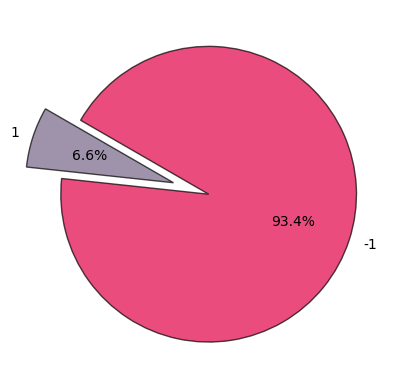

In [38]:
# Combine features and labels
dataset = pd.concat([filtered_features, labels], axis=1)
colors = ('#e20047', '#766688')
xpl = [0.0, 0.25]
dataset['labels'].value_counts().plot(kind='pie', colors=colors, legend=None, explode=xpl, ylabel='', counterclock=False, startangle=150, wedgeprops={'alpha':0.7, 'edgecolor' : 'black','linewidth': 1, 'antialiased': True}, autopct='%1.1f%%')


Clearly the dataset is imbalanced

## Part 4.

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
x_scaled = scaler.fit_transform(filtered_features)


# Part 5.

In [44]:
labels = labels.values.reshape(-1)
labels

array([-1, -1,  1, ..., -1, -1, -1])

In [45]:
from sklearn.preprocessing import LabelEncoder
# Split the data
x_train, x_test, y_train, y_test = train_test_split(x_scaled, labels, test_size=1.0/3.0)
encoder = LabelEncoder()

encoder.fit(y_train)
y_train_labels = encoder.transform(y_train)
y_test_labels = encoder.transform(y_test)

In [47]:
import numpy as np
np.unique(y_train_labels)

array([0, 1])

In [48]:
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn import metrics #for checking the model accuracy
log = LogisticRegression(max_iter=250)
log.fit(x_train,y_train_labels)
prediction=log.predict(x_test)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction,y_test_labels))


The accuracy of the Logistic Regression is 0.892925430210325


# Part 6.

In [49]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_labels, prediction)
print(confusion_matrix)

[[463  28]
 [ 28   4]]


### Classification report on the training data

In [58]:
from sklearn.metrics import classification_report
prediction=log.predict(x_train)
accuracy = metrics.accuracy_score(y_train_labels, prediction)
F1_score = metrics.f1_score(y_train_labels, prediction)
precision = metrics.precision_score(y_train_labels, prediction)
recall = metrics.recall_score(y_train_labels, prediction)
accuracy, F1_score, precision, recall

(0.9952107279693486, 0.9640287769784173, 1.0, 0.9305555555555556)

### Classification report on the testing data

In [59]:
from sklearn.metrics import classification_report
prediction=log.predict(x_test)
accuracy = metrics.accuracy_score(y_test_labels, prediction)
F1_score = metrics.f1_score(y_test_labels, prediction)
precision = metrics.precision_score(y_test_labels, prediction)
recall = metrics.recall_score(y_test_labels, prediction)
accuracy, F1_score, precision, recall

(0.892925430210325, 0.125, 0.125, 0.125)

# Part 6.

Experiment: 0
Experiment: 1
Experiment: 2
Experiment: 3
Experiment: 4
Training Accuracy Metrics:
[0.9971264367816092, 0.9990421455938697, 0.9971264367816092, 0.9990421455938697, 0.9952107279693486]
Training F1 Score:
[0.9770992366412213, 0.991869918699187, 0.9770992366412213, 0.9921259842519685, 0.9640287769784173]
Training Precision Score:
[1.0, 1.0, 1.0, 1.0, 1.0]
Training Recall Score:
[0.9552238805970149, 0.9838709677419355, 0.9552238805970149, 0.984375, 0.9305555555555556]
Tesing Accuracy Metrics:
[0.8948374760994264, 0.8795411089866156, 0.892925430210325, 0.8967495219885278, 0.8967495219885278]
Training F1 Score:
[0.28571428571428575, 0.136986301369863, 0.2631578947368421, 0.20588235294117646, 0.09999999999999999]
Training Precision Score:
[0.275, 0.16129032258064516, 0.2564102564102564, 0.25, 0.10714285714285714]
Training Recall Score:
[0.2972972972972973, 0.11904761904761904, 0.2702702702702703, 0.175, 0.09375]


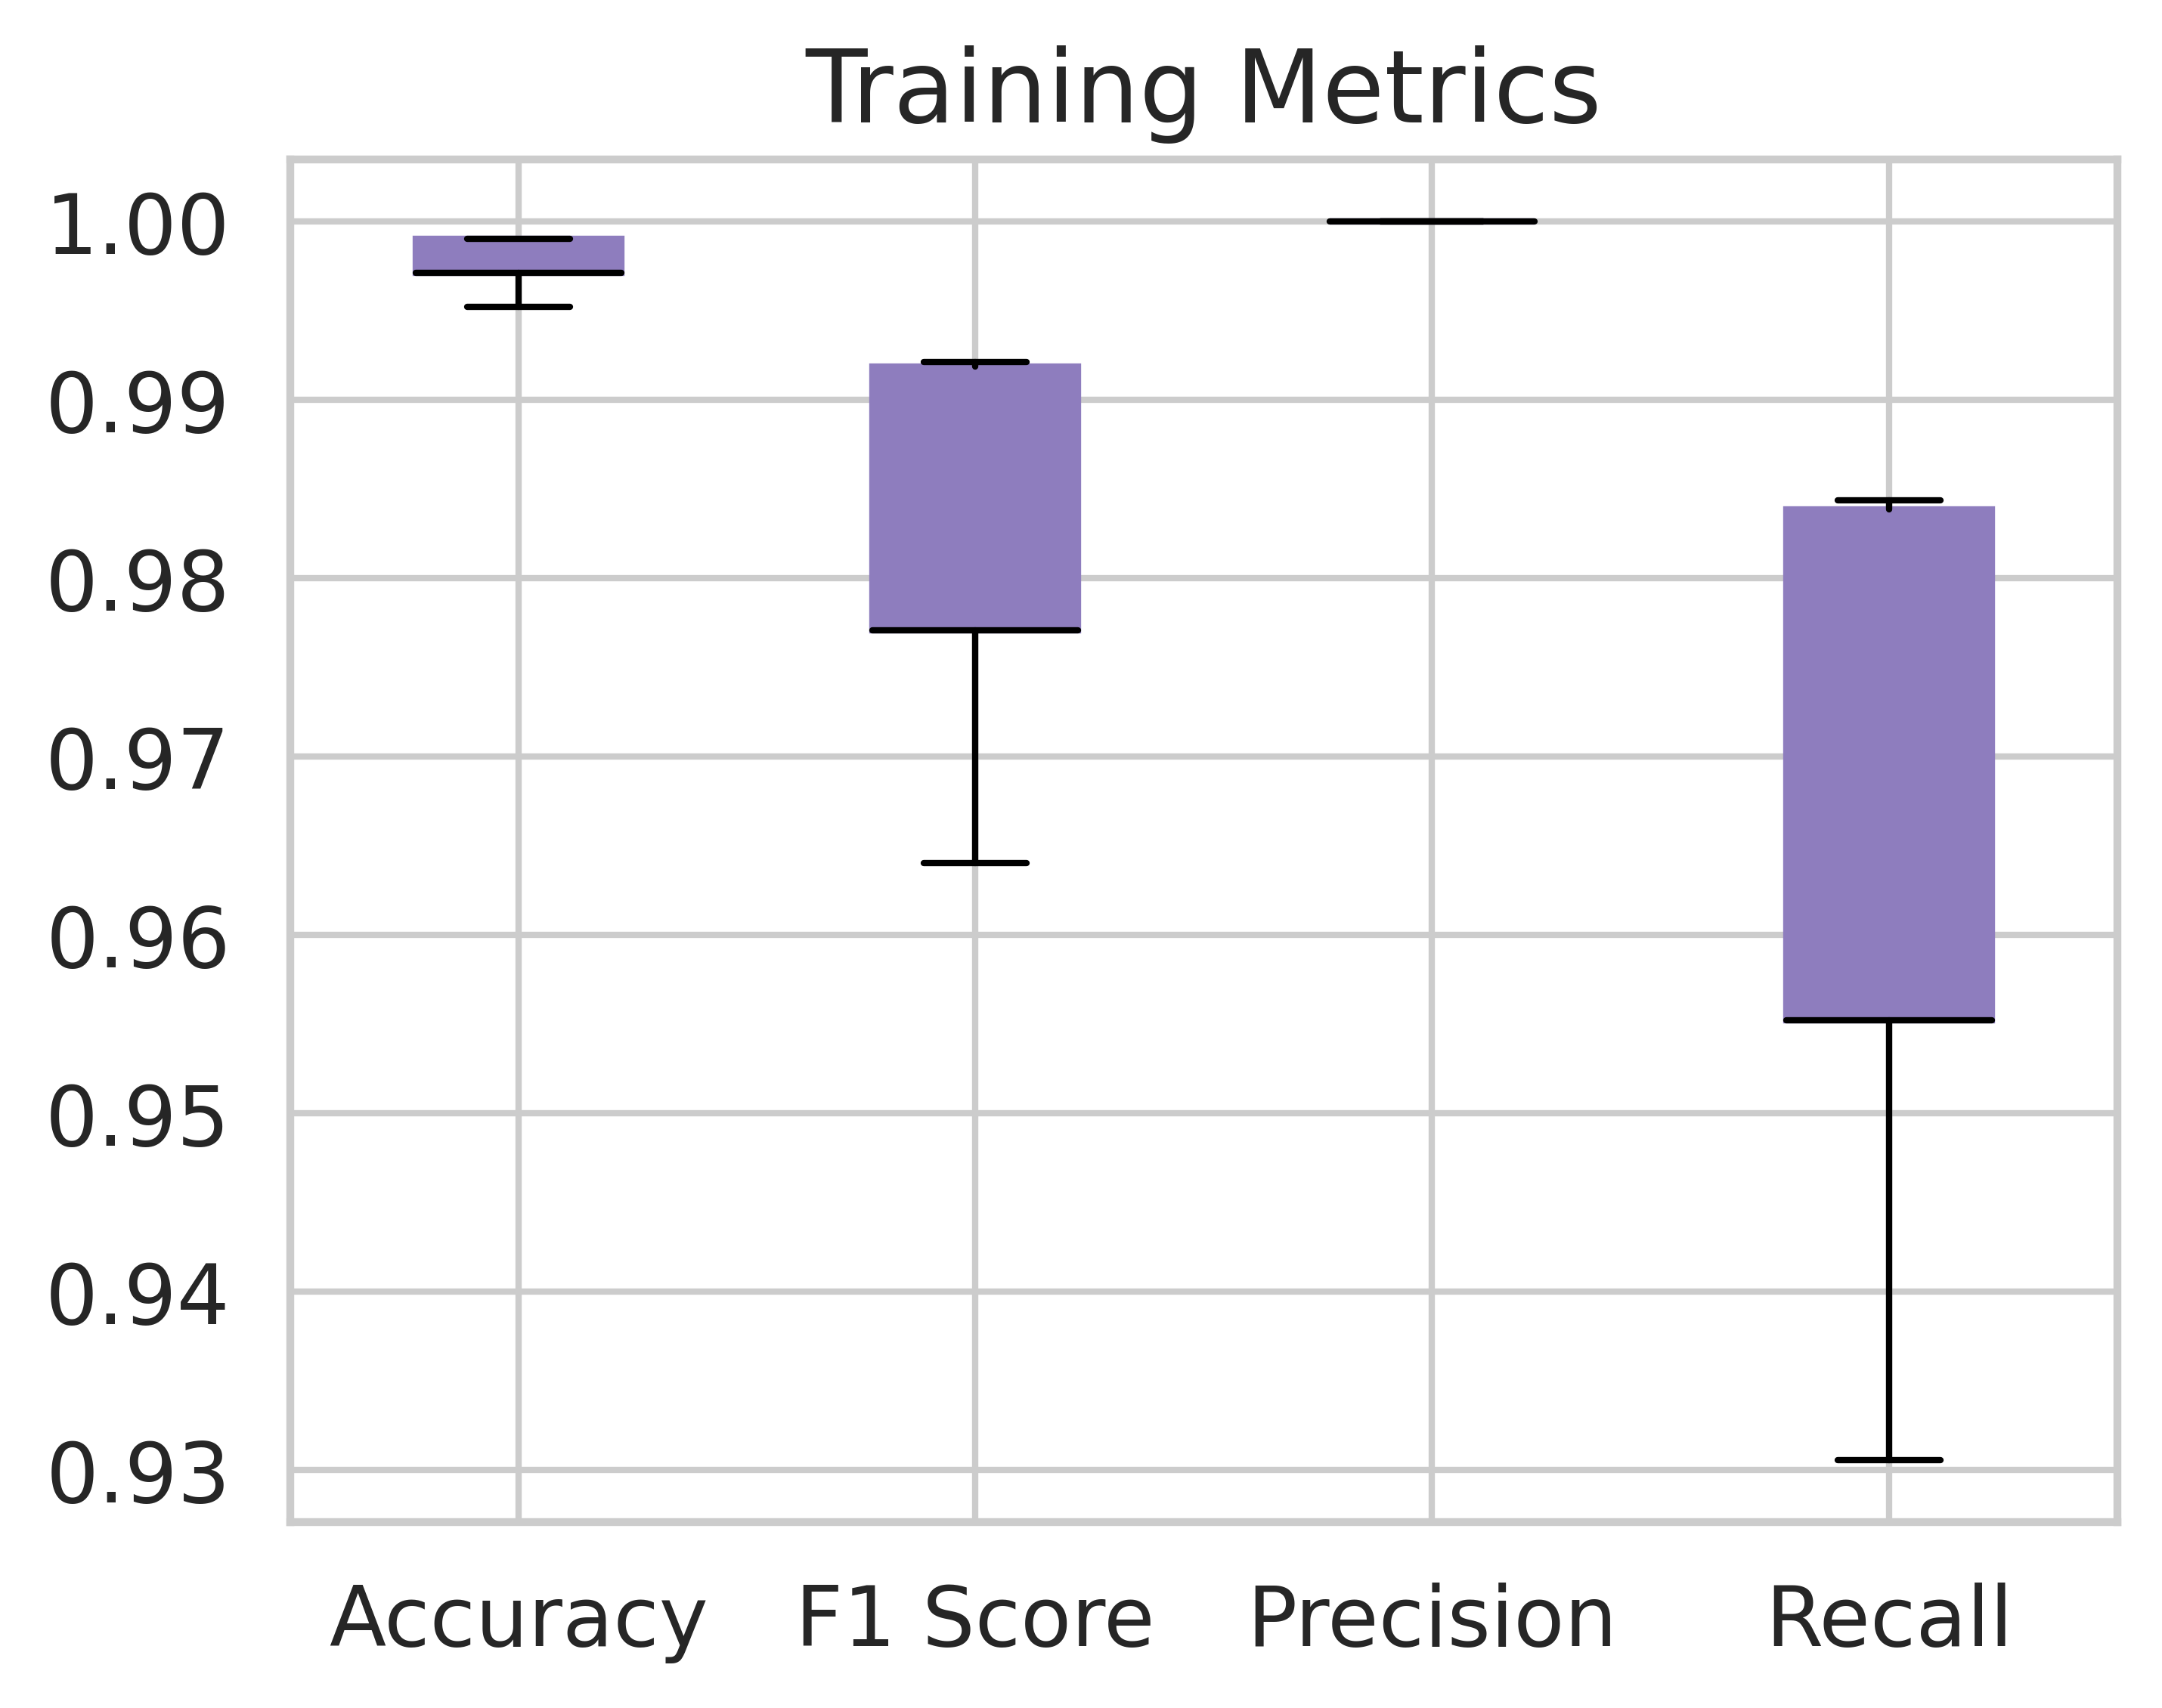

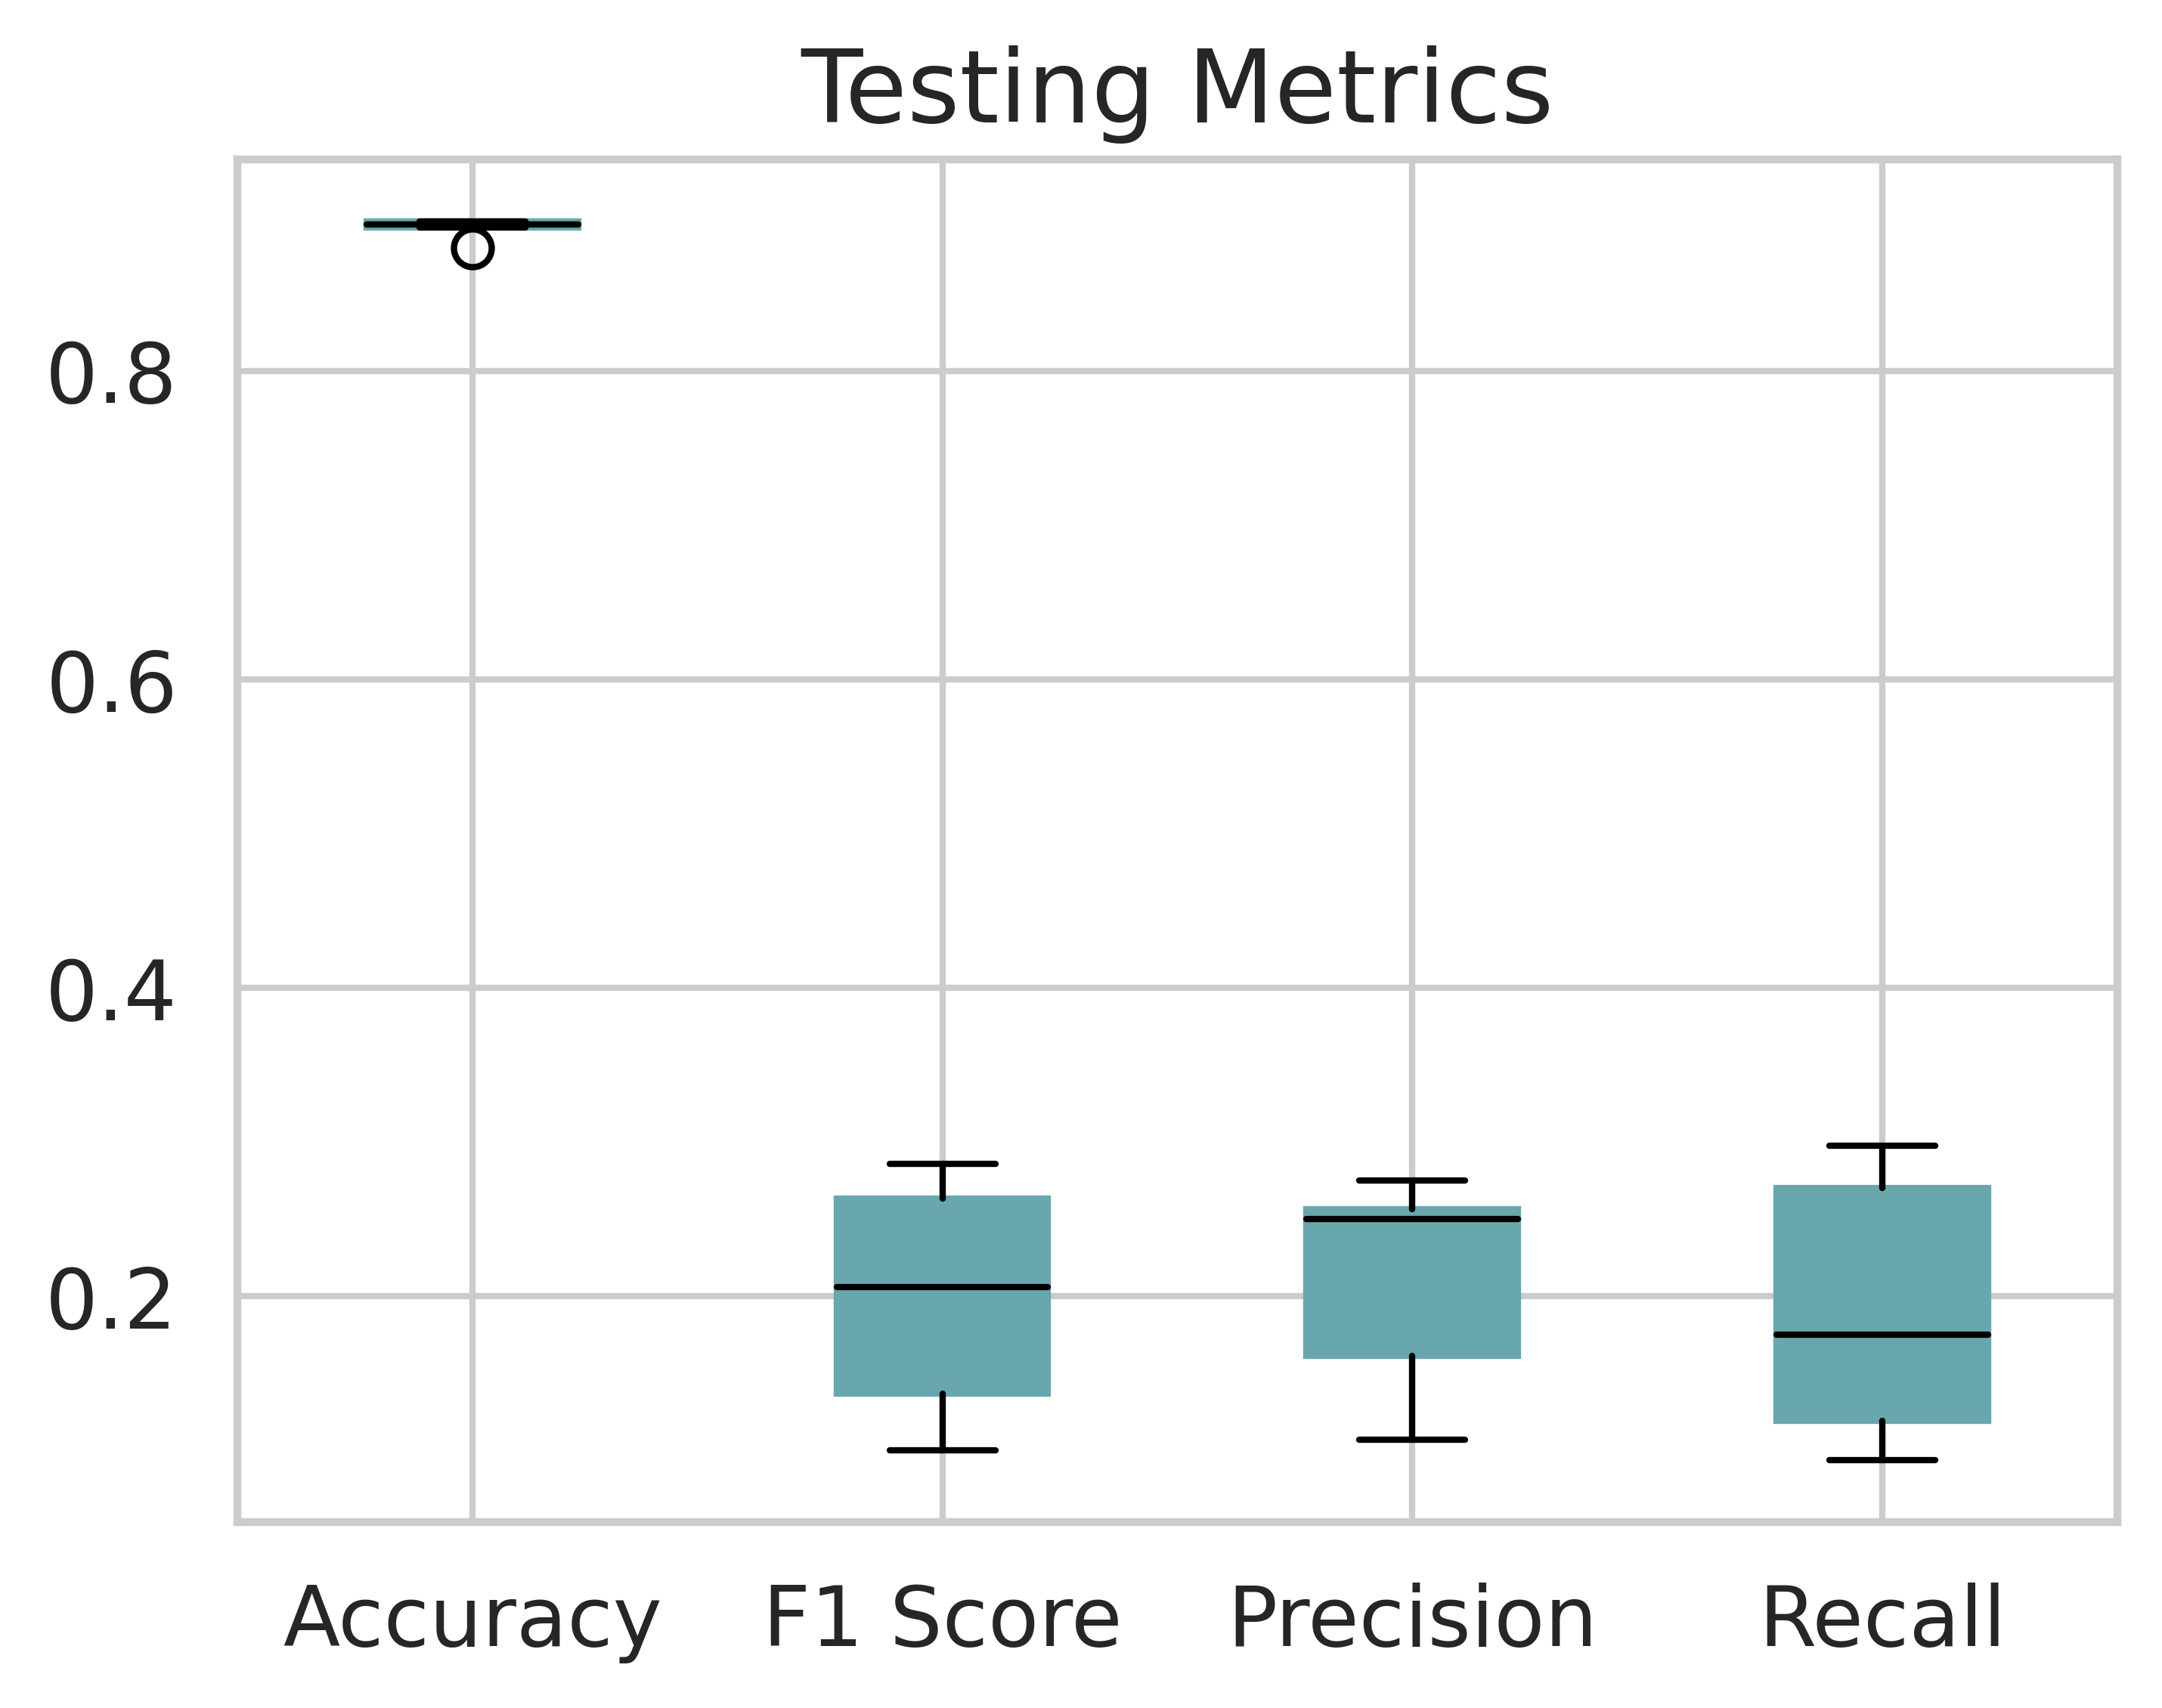

In [72]:
accuracy_vec_train = []
F1_score_vec_train = []
precision_vec_train = []
recall_vec_train = []
accuracy_vec_test = []
F1_score_vec_test = []
precision_vec_test = []
recall_vec_test = []
for i in range(0, 5):
    print("Experiment: {}".format(i))
    x_train, x_test, y_train, y_test = train_test_split(x_scaled, labels, test_size=1.0/3.0)
    encoder = LabelEncoder()

    encoder.fit(y_train)
    y_train_labels = encoder.transform(y_train)
    y_test_labels = encoder.transform(y_test)
    
    log = LogisticRegression(max_iter=250)
    log.fit(x_train,y_train_labels)
    
    prediction=log.predict(x_train)
    accuracy = metrics.accuracy_score(y_train_labels, prediction)
    F1_score = metrics.f1_score(y_train_labels, prediction)
    precision = metrics.precision_score(y_train_labels, prediction)
    recall = metrics.recall_score(y_train_labels, prediction)

    accuracy_vec_train.append(accuracy)
    F1_score_vec_train.append(F1_score)
    precision_vec_train.append(precision)
    recall_vec_train.append(recall)
    
    prediction=log.predict(x_test)
    accuracy = metrics.accuracy_score(y_test_labels, prediction)
    F1_score = metrics.f1_score(y_test_labels, prediction)
    precision = metrics.precision_score(y_test_labels, prediction)
    recall = metrics.recall_score(y_test_labels, prediction)
    
    accuracy_vec_test.append(accuracy)
    F1_score_vec_test.append(F1_score)
    precision_vec_test.append(precision)
    recall_vec_test.append(recall)
    
print("Training Accuracy Metrics:")
print(accuracy_vec_train)
print("Training F1 Score:")
print(F1_score_vec_train)
print("Training Precision Score:")
print(precision_vec_train)
print("Training Recall Score:")
print(recall_vec_train)

print("Tesing Accuracy Metrics:")
print(accuracy_vec_test)
print("Training F1 Score:")
print(F1_score_vec_test)
print("Training Precision Score:")
print(precision_vec_test)
print("Training Recall Score:")
print(recall_vec_test)

train_color = "#8E7DBE"  # Soft Purple
test_color = "#68A7AD"   # Teal

# Training Metrics Boxplot
plt.figure(figsize=(5, 4), dpi=600)
plt.boxplot([accuracy_vec_train, F1_score_vec_train, precision_vec_train, recall_vec_train],
            patch_artist=True,
            boxprops=dict(facecolor=train_color, color=train_color),
            medianprops=dict(color='black'))
plt.xticks([1, 2, 3, 4], ['Accuracy', 'F1 Score', 'Precision', 'Recall'])
plt.title('Training Metrics', fontsize=16)
plt.tight_layout()
plt.show()

# Testing Metrics Boxplot
plt.figure(figsize=(5, 4), dpi=600)
plt.boxplot([accuracy_vec_test, F1_score_vec_test, precision_vec_test, recall_vec_test],
            patch_artist=True,
            boxprops=dict(facecolor=test_color, color=test_color),
            medianprops=dict(color='black'))
plt.xticks([1, 2, 3, 4], ['Accuracy', 'F1 Score', 'Precision', 'Recall'])
plt.title('Testing Metrics', fontsize=16)
plt.tight_layout()
plt.show()

From the box plot observation, we find out that testing metrics and more stable than training metrics. However, overall training metrics are higher than testing metrics. Precision is perfect (1.0) in all training runs, which often indicates the model predicts the positive class very confidently on the training set. On the test data, F1 Score is very low (as low as 0.09) and highly unstable across runs. Precision and Recall on the test set are poor and inconsistent—values vary widely between experiments. We can make the conclusion that the model generalizes poorly. Possible class imbalance affecting F1 and Recall. Model might be biased toward the majority class, leading to unreliable predictions on unseen data.

 # 9. Multiple Regression with PyTorch

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("https://raw.githubusercontent.com/rahulbhadani/CPE490_590_Sp2025/refs/heads/master/Data/CombinedCyclePowerPlant/Folds5x2_pp.csv")
data

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43
...,...,...,...,...,...
9563,15.12,48.92,1011.80,72.93,462.59
9564,33.41,77.95,1010.30,59.72,432.90
9565,15.99,43.34,1014.20,78.66,465.96
9566,17.65,59.87,1018.58,94.65,450.93


## Part 1.

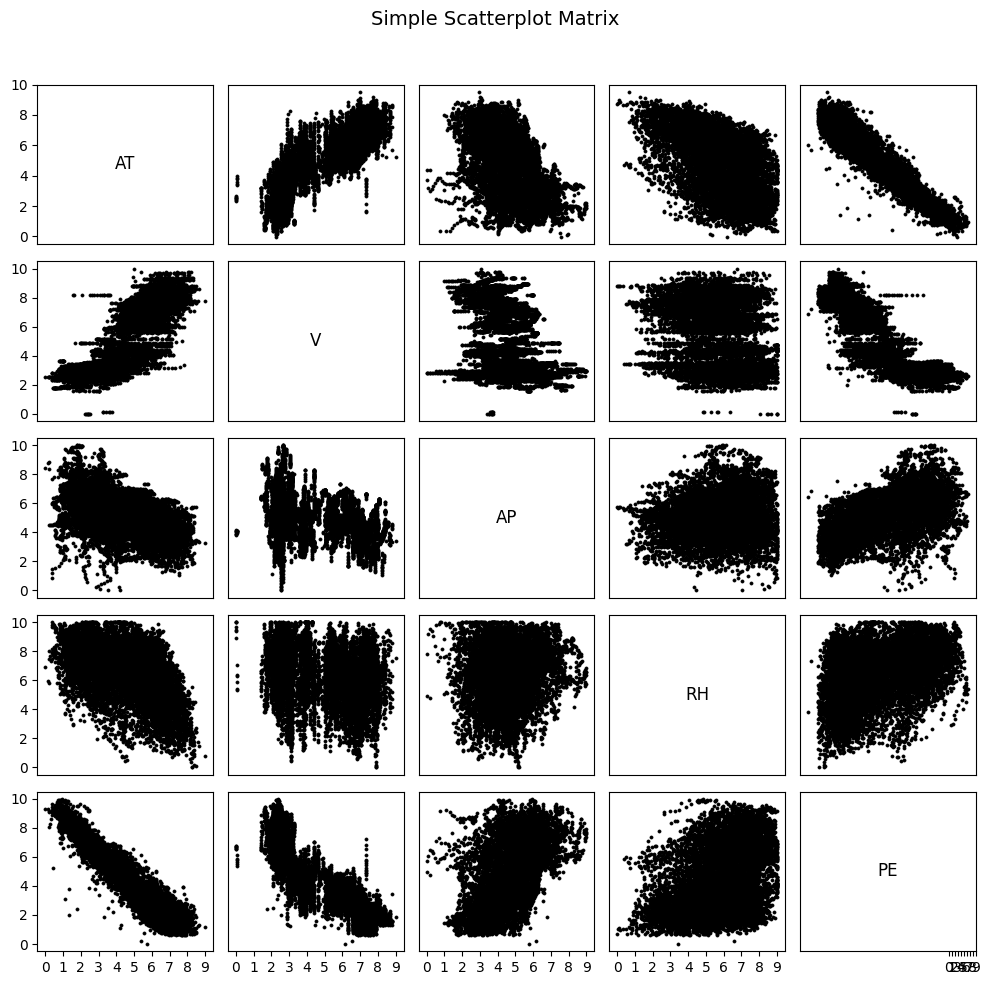

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import scatter_matrix

def create_scatterplot_matrix(data, figsize=(10, 10), diagonal_visible=True):
    """
    Create a scatterplot matrix for the given dataset.
    
    Parameters:
    -----------
    data : pandas DataFrame
        The dataset to visualize
    figsize : tuple, optional
        Figure size (width, height) in inches
    diagonal_visible : bool, optional
        Whether to show the diagonal plots
        
    Returns:
    --------
    fig, axes : matplotlib figure and axes objects
    """
    # Create a scatter matrix
    fig, axes = plt.subplots(nrows=len(data.columns), ncols=len(data.columns), figsize=figsize)
    
    # Set the figure title
    fig.suptitle('Simple Scatterplot Matrix', fontsize=14)
    
    # Adjust the layout
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    # Get variable names
    variables = data.columns
    
    # Loop through all axes
    for i, row_var in enumerate(variables):
        for j, col_var in enumerate(variables):
            ax = axes[i, j]
            
            # Clear diagonal if not needed
            if i == j and not diagonal_visible:
                ax.text(0.5, 0.5, variables[i], 
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])
            # Plot scatterplot for off-diagonal elements
            elif i != j:
                ax.scatter(data[col_var], data[row_var], s=5, edgecolor='black', 
                        linewidth=0.5, facecolor='black')
            # Plot variable name on diagonal
            else:
                ax.text(0.5, 0.5, variables[i], 
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])
                
            # Only show x-ticks for bottom row
            if i < len(variables) - 1:
                ax.set_xticks([])
            else:
                ax.set_xticks(np.linspace(min(data[col_var]), max(data[col_var]), 10))
                ax.set_xticklabels([str(int(x)) for x in np.linspace(0, 9, 10)])
                
            # Only show y-ticks for leftmost column
            if j > 0:
                ax.set_yticks([])
            else:
                ax.set_yticks(np.linspace(min(data[row_var]), max(data[row_var]), 6))
                ax.set_yticklabels([str(int(x*2)) for x in range(6)])
                
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for title
    return fig, axes

fig, axes = create_scatterplot_matrix(data)
plt.show()

# Part 2.

In [8]:
X = data[['AT', 'V', 'AP', 'RH']]
y = data['PE']

In [16]:
from statsmodels.base.model import GenericLikelihoodModel
import statsmodels.api as sm

class CauchyRegression(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwargs):
        super().__init__(endog, exog, **kwargs)
    
    def nloglikeobs(self, params):
        residuals = self.endog - self.exog @ params
        return np.log(1 + residuals**2)  # c=1
    
    def fit(self, start_params=None, maxiter=10000, **kwargs):
        start_params = start_params if start_params else np.zeros(self.exog.shape[1])
        return super().fit(start_params=start_params, maxiter=maxiter, **kwargs)
    
    def predict(self, params, exog=None, *args, **kwargs):
        """
        Predict values for the model using parameters and exogenous data.
        
        Parameters
        ----------
        params : array_like
            The parameters of the model.
        exog : array_like, optional
            Exogenous data. If None, the model's exog data is used.
        
        Returns
        -------
        ndarray
            The predicted values.
        """
        if exog is None:
            exog = self.exog
            
        return exog @ params

# Fit Cauchy loss model
# Add a column of 1s for the intercept
X_with_intercept = sm.add_constant(X)
model_cauchy = CauchyRegression(y, X_with_intercept).fit()
print(model_cauchy.summary())

Optimization terminated successfully.
         Current function value: 2.421847
         Iterations: 557
         Function evaluations: 908
                           CauchyRegression Results                           
Dep. Variable:                     PE   Log-Likelihood:                -23172.
Model:               CauchyRegression   AIC:                         4.635e+04
Method:            Maximum Likelihood   BIC:                         4.639e+04
Date:                Sun, 23 Mar 2025                                         
Time:                        15:36:37                                         
No. Observations:                9568                                         
Df Residuals:                    9563                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

## Part 3.


Coefficient of fitted values are 0.3753 (intercept), and -1.7136, -0.3052, 0.5039, -0.0922

## Part 4.
The final loss value is  2.421847

## Part 5.
95% confidence interval for the coefficients tells us that coeffcients don't have too large uncertainty

## Part 6.

Text(0.5, 1.0, 'RH vs residuals')

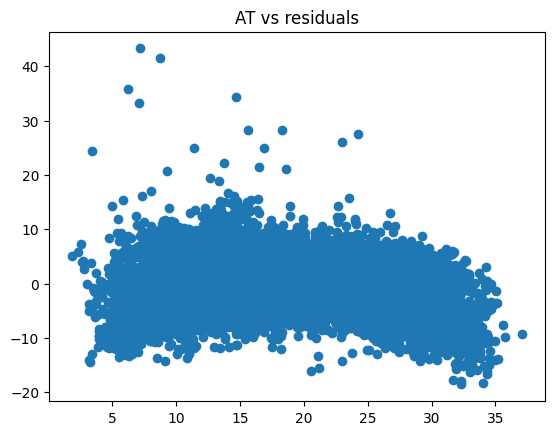

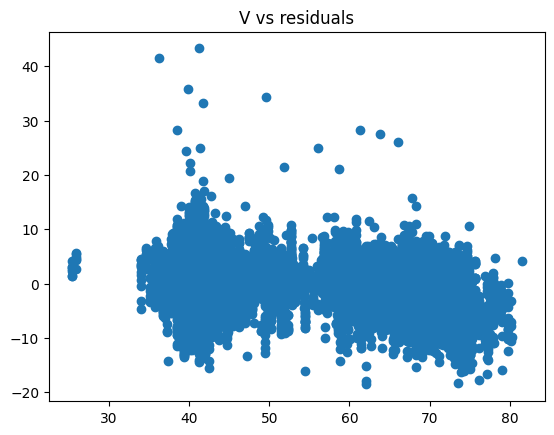

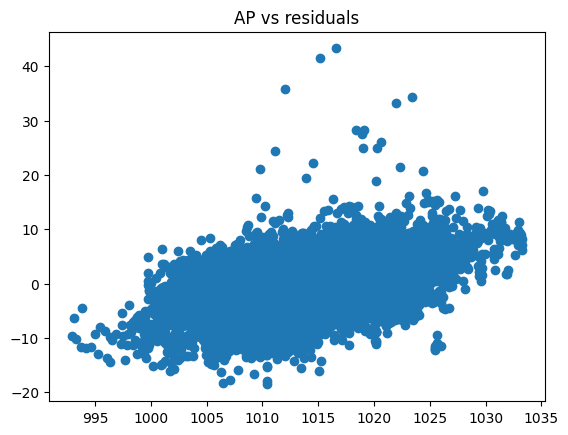

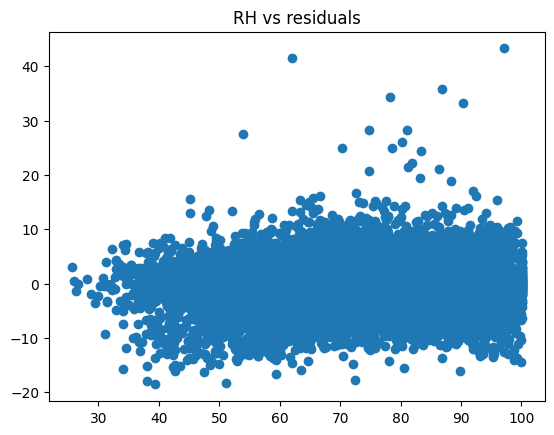

In [30]:
y_hat = model_cauchy.predict(X_with_intercept)
residuals = y_hat - y
fig, ax = plt.subplots(1,1)
ax.scatter(data['AT'], residuals)
ax.set_title('AT vs residuals')
fig, ax = plt.subplots(1,1)
ax.scatter(data['V'], residuals)
ax.set_title('V vs residuals')
fig, ax = plt.subplots(1,1)
ax.scatter(data['AP'], residuals)
ax.set_title('AP vs residuals')
fig, ax = plt.subplots(1,1)
ax.scatter(data['RH'], residuals)
ax.set_title('RH vs residuals')

**Residual plot tells that the normality assumptions about the residuals hold**

## Part 7.

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert data to tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)


In [41]:
import torch
import torch.optim as optim

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def cauchy_loss(y_pred, y_true):
    return torch.sum(torch.log(1 + (y_pred - y_true)**2))

# Move tensors to GPU
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

# Initialize parameters directly and move to GPU
w = torch.rand(4, requires_grad=True, device=device)  # Weights for AT, V, AP, RH
w_0 = torch.rand(1, requires_grad=True, device=device)  # Intercept/bias

# Define the model function explicitly
def model_cauchy(X):
    # X has shape [batch_size, 4]
    # Calculate: w_0 + w_1*x_1 + w_2*x_2 + w_3*x_3 + w_4*x_4
    return torch.matmul(X, w) + w_0

optimizer_cauchy = optim.Adam([w, w_0], lr=0.1)

epochs = 1000
for epoch in range(epochs):
    optimizer_cauchy.zero_grad()
    outputs = model_cauchy(X_tensor)
    loss = cauchy_loss(outputs, y_tensor)
    loss.backward()
    optimizer_cauchy.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}\n')
        
print(f"Intercept (w_0): {w_0.item():.4f}")
print("Coefficients:")
feature_names = ["AT", "V", "AP", "RH"]
for i, name in enumerate(feature_names):
    print(f"  {name}: {w[i].item():.4f}")

Using device: cuda
Epoch 100, Loss: 443646592.0

Epoch 200, Loss: 438479680.0

Epoch 300, Loss: 435881728.0

Epoch 400, Loss: 435353056.0

Epoch 500, Loss: 435297792.0

Epoch 600, Loss: 435290496.0

Epoch 700, Loss: 435287296.0

Epoch 800, Loss: 435285440.0

Epoch 900, Loss: 435284352.0

Epoch 1000, Loss: 435283712.0

Intercept (w_0): 0.3304
Coefficients:
  AT: 0.2871
  V: -0.0440
  AP: 0.4308
  RH: 0.0580


## Alternative Implementation

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class CauchyModel(nn.Module):
    def __init__(self, input_size):
        super(CauchyModel, self).__init__()
        # Initialize parameters directly
        self.weights = nn.Parameter(torch.zeros(input_size))
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        # Implement the equation: y = w0 + w1*x1 + w2*x2 + w3*x3 + w4*x4
        # x shape is [batch_size, input_size]
        # Multiply each feature by its corresponding weight
        weighted_sum = torch.matmul(x, self.weights)
        # Add the bias term
        return weighted_sum + self.bias

# Define the loss function
def cauchy_loss(y_pred, y_true):
    return torch.mean(torch.log(1 + (y_pred - y_true)**2))

# Initialize the model, assuming 4 input features (AT, V, AP, RH)
model_cauchy = CauchyModel(input_size=4)
# Move the model to the GPU
model_cauchy.to(device)

# Move input data to the GPU
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

optimizer_cauchy = optim.Adam(model_cauchy.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer_cauchy.zero_grad()
    outputs = model_cauchy(X_tensor)
    loss = cauchy_loss(outputs, y_tensor)
    loss.backward()
    optimizer_cauchy.step()
    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}\n')

# After training, print the parameters
print(f"Intercept (bias): {model_cauchy.bias.item():.4f}")
print("Coefficients:")
feature_names = ["AT", "V", "AP", "RH"]
for i, name in enumerate(feature_names):
    print(f"  {name}: {model_cauchy.weights[i].item():.4f}")

Using device: cuda
Epoch 50, Loss: 5.274984836578369

Epoch 100, Loss: 4.8447442054748535

Epoch 150, Loss: 4.8154826164245605

Epoch 200, Loss: 4.791094779968262

Epoch 250, Loss: 4.77315616607666

Epoch 300, Loss: 4.762795448303223

Epoch 350, Loss: 4.75792932510376

Epoch 400, Loss: 4.756007194519043

Epoch 450, Loss: 4.7553324699401855

Epoch 500, Loss: 4.755096435546875

Epoch 550, Loss: 4.754994869232178

Epoch 600, Loss: 4.7549357414245605

Epoch 650, Loss: 4.754892826080322

Epoch 700, Loss: 4.754859924316406

Epoch 750, Loss: 4.754833698272705

Epoch 800, Loss: 4.7548136711120605

Epoch 850, Loss: 4.754798889160156

Epoch 900, Loss: 4.754787445068359

Epoch 950, Loss: 4.754778861999512

Epoch 1000, Loss: 4.754772663116455

Intercept (bias): 0.4893
Coefficients:
  AT: 0.2596
  V: -0.0304
  AP: 0.4307
  RH: 0.0535
